<a href="https://colab.research.google.com/github/speed8928/mybook/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')
import os
cwd = os.getcwd()

os.chdir("/content/drive/MyDrive/Colab Notebooks/pytorch")

%pip install calflops

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torchvision
import torchvision.transforms as transforms
from model.resnet import ResNet, Bottleneck
from model.resnet_lite import ResNetLite
from calflops import calculate_flops


In [22]:
# ---------------------
# Load CIFAR-10 test data
# ---------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
device = torch.device("cuda")

In [23]:
# ---------------------
# Load models
# ---------------------
model_orig = ResNet(block=Bottleneck, num_blocks=[3, 4, 6, 3], num_classes=10)
model_orig.load_state_dict(torch.load("checkpoints/resnet50_cifar10.pth", map_location=device))
model_orig.to(device)
model_orig.eval()

model_gen = ResNetLite(num_classes=10)
model_gen.load_state_dict(torch.load("checkpoints/resnet_lite_cifar10.pth", map_location=device))
model_gen.to(device)
model_gen.eval()

ResNetLite(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlockLite(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlockLite(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3)

In [24]:
def benchmark(model, name):


    input_shape = (1, 3, 32, 32)
    flops, macs, params = calculate_flops(model=model,
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4,
                                      print_detailed=False)

    print("Model name: %s FLOPs:%s   MACs:%s   Params:%s \n" %(name, flops, macs, params))


    correct = 0
    total = 0
    start = time.time()
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    end = time.time()

    print(f"Inference time for {name}: {end - start:.4f} seconds")
    print(f"Test Accuracy: {100.*correct/total:.2f}%")

🖼️ CIFAR-10 test images in testset


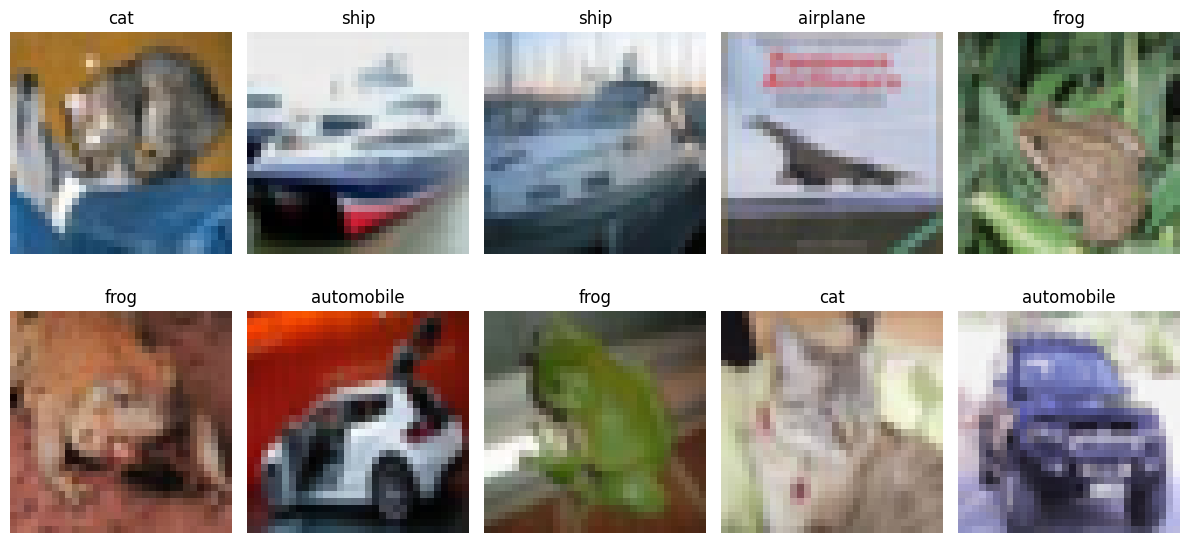

🔁 Benchmarking ResNet-original vs ResNet-gen Inference on CPU

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  23.52 M 
fwd MACs:                                                               1.2978 GMACs
fwd FLOPs:                                                              2.6055 GFLOPS
fwd+bwd MACs:                                                           3.8935 GMACs
fwd+bwd FLOPs:                                                          7.8165 GFLOPS
--------------------------------------------------

In [25]:


classes = testset.classes

def imshow(img):
    img = img * torch.tensor((0.2023, 0.1994, 0.2010)).view(3,1,1) + torch.tensor((0.4914, 0.4822, 0.4465)).view(3,1,1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get a batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Plot first 10
plt.figure(figsize=(12, 6))
for idx in range(10):
    plt.subplot(2, 5, idx + 1)
    imshow(images[idx])
    plt.title(classes[labels[idx]])
plt.tight_layout()
plt.savefig("cifar10_first10.png")
print("🖼️ CIFAR-10 test images in testset")
plt.show()



print("🔁 Benchmarking ResNet-original vs ResNet-gen Inference on gpu")
benchmark(model_orig, "Original Model")
benchmark(model_gen, "Lite Model")